# Convolution Neural Networks - Prediction Heatmap

## Written by: Rodrigo Escandon
### Transfer Learning Model: InceptionResNetV2

# Executive Summary

A prediction heatmap was created by extracting the values from the last convolutional layer from a Convolutional Neural Network model. The purpose of this heatmap is to show the areas that most contribute to a prediction result. This allows the user a level of transperancy and understanding of how the model is coming to its conclusion. This process can be used at the model building stage to understand model performances or at the model end stage for human in the loop review.

## Model Performance

In the prediciton heatmap assume that the shaded red areas are the main contributors to the model prediction. If a model is performing adequately, these areas should be located in the image where the labelled objects are found. 

In [1]:
#Importing the Keras libraries and packages. 
#Keras will be using TensorFlow as a backend.
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
import matplotlib.cm as cm
from matplotlib import pyplot as plt

Tensorflow=2.10.0 

Keras=2.10.0 

OpenCV=4.7.0 

Numpy=1.21.5 

In [2]:
print(tf.__version__,"Tensorflow")
print(keras.__version__,"Keras")
print(cv2.__version__,"OpenCV")
print(np.__version__,"Numpy")

2.10.0 Tensorflow
2.10.0 Keras
4.7.0 OpenCV
1.21.5 Numpy


In [3]:
#Target sizes
ts=299

In [4]:
#CV Transfer Model Download and Condition
#Maintaining "include_top=True" so the full model is downloaded
transfer_model=tf.keras.applications.InceptionResNetV2(include_top=True,weights='imagenet',input_shape=(ts,ts,3))

In [5]:
#Data upload, resizing, predicting and prediction overlay on image
def grad_cam(path,name,tranfer_model,layer_name):
    
    image=cv2.imread(path+name)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,[ts,ts])
    image_pred=np.expand_dims(image,axis=0)
    image_pred=preprocess_input(image_pred)
    res_p=transfer_model.predict(image_pred)
    #Check the last convolutional layer in the model and input string in "get_layer"
    #Use transfer_model.summary() to find input name
    ext_model=tf.keras.models.Model([transfer_model.inputs],[transfer_model.get_layer(layer_name).output,
                                                         transfer_model.output])
    pred_index=None
    with tf.GradientTape() as tape:
        last_conv,preds=ext_model(image_pred)
        if pred_index is None:
            pred_index=tf.argmax(preds[0])
        class_channel=preds[:,pred_index]
    grads=tape.gradient(class_channel,last_conv)
    pooled_grads=tf.reduce_mean(grads,axis=(0,1,2))
    last_conv=last_conv[0]
    heatmap=last_conv@pooled_grads[...,tf.newaxis]
    heatmap=tf.squeeze(heatmap)
    heatmap=tf.maximum(heatmap,0)/tf.math.reduce_max(heatmap)
    heatmap=np.uint8(255*heatmap)
    jet=cm.get_cmap('jet')
    jet_colors=jet(np.arange(256))[:,:3]
    jet_heatmap=jet_colors[heatmap]
    jet_heatmap=cv2.resize(jet_heatmap,[ts,ts])
    image_map=cv2.addWeighted(image,0.5,np.uint8(jet_heatmap*255),0.4,0)
    results=decode_predictions(res_p, top=1)[0]
    
    return image_map,results,jet_heatmap,image

In [6]:
path='bears/'
name_bear='black_00000043.jpg'
name_teddy='teddy_00000014.jpg'
layer_name='conv_7b_ac'
bear_map,bear_results,bear_heatmap,bear_image=grad_cam(path,name_bear,transfer_model,layer_name)
teddy_map,teddy_results,teddy_heatmap,teddy_image=grad_cam(path,name_teddy,transfer_model,layer_name)

1/1 [==============================] - 0s 447ms/step


Predicted: American_black_bear
Model_Score: 0.82


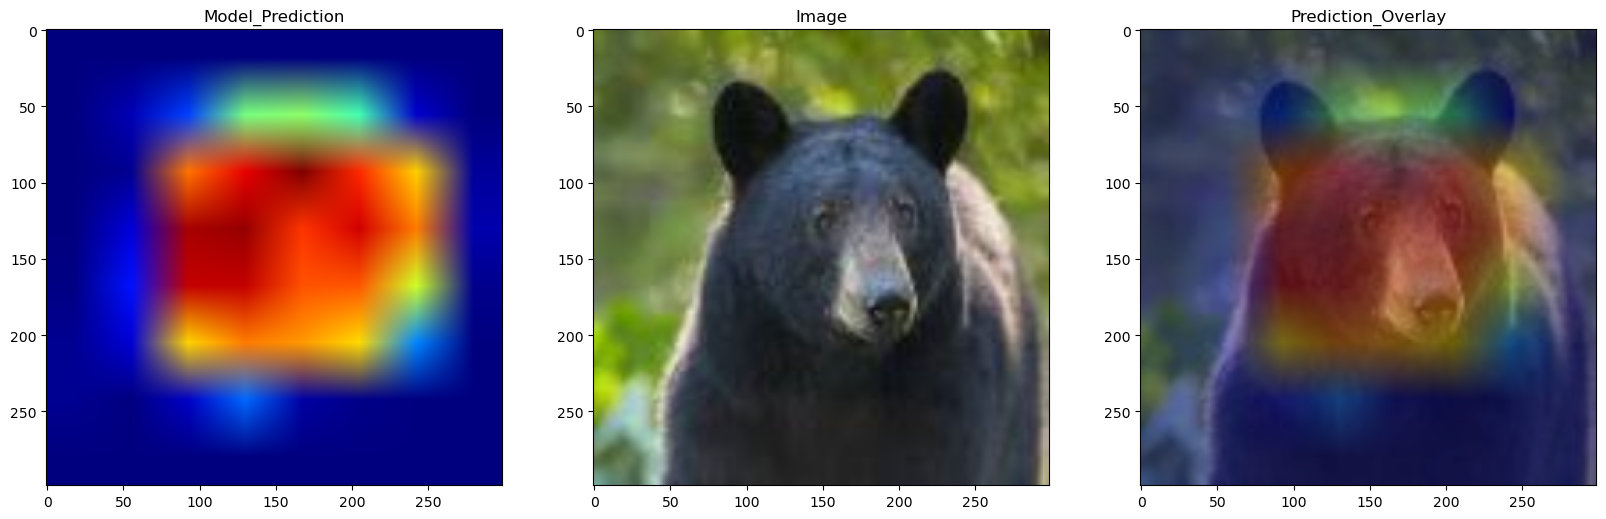

In [7]:
#Results of model prediction and subsequent overlay prediction on analyzed image
#Areas were shades of red are located can be assumed as the main contributors to the model prediction
print('Predicted:', bear_results[0][1])
print('Model_Score:', round(bear_results[0][2],2))
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,20))
ax1.imshow(cv2.resize(bear_heatmap,[ts,ts]))
ax1.title.set_text('Model_Prediction')
ax2.imshow(np.squeeze(bear_image))
ax2.title.set_text('Image')
ax3.imshow(np.uint8(bear_map))
ax3.title.set_text('Prediction_Overlay')

Predicted: teddy
Model_Score: 0.96


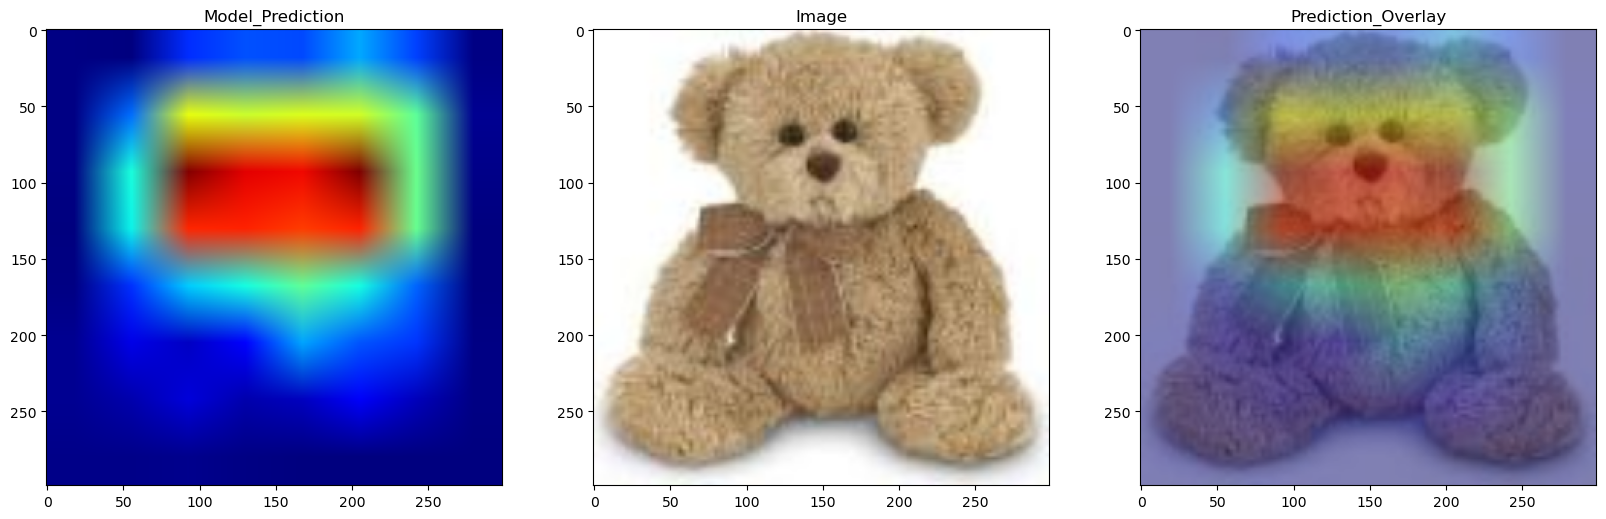

In [8]:
#Results of model prediction and subsequent overlay prediction on analyzed image
#Areas were shades of red are located can be assumed as the main contributors to the model prediction
print('Predicted:', teddy_results[0][1])
print('Model_Score:', round(teddy_results[0][2],2))
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,20))
ax1.imshow(cv2.resize(teddy_heatmap,[ts,ts]))
ax1.title.set_text('Model_Prediction')
ax2.imshow(np.squeeze(teddy_image))
ax2.title.set_text('Image')
ax3.imshow(np.uint8(teddy_map))
ax3.title.set_text('Prediction_Overlay')